In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pymatting
from pymatting import *

In [2]:
!pip install PyMatting

   ---------------------------------------- 0.0/53.0 kB ? eta -:--:--
   ------------------------------ --------- 41.0/53.0 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 53.0/53.0 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.7 MB 5.9 MB/s eta 0:00:01
   ---------- ----------------------------- 0.7/2.7 MB 8.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.2/2.7 MB 15.3 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 17.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 2.0/28.1 MB 123.5 MB/s eta 0:00:01
   ---- ----------------------------------- 2.9/28.1 MB 30.7 MB/s eta 0:00:01
   ---- ----------------------------------- 3.3/28.1 MB 23.2 MB/s eta 0:00:02
   ----- ---------------------------------- 4.0/28.1 MB 23.3 MB/s eta 0:00:02
   ------- ---

In [70]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")

trimap.shape

(256, 256)

In [8]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")
alpha = estimate_alpha_cf(
    image,
    trimap,
    laplacian_kwargs={"epsilon": 1e-6},
    cg_kwargs={"maxiter":2000})

save_image("123.png", alpha)

In [5]:
from pymatting import *
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")
alpha = estimate_alpha_knn(
    image,
    trimap,
    laplacian_kwargs={"n_neighbors": [15, 10]},
    cg_kwargs={"maxiter":2000})
save_image("knn.png", alpha)


In [6]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")
alpha = estimate_alpha_lbdm(
    image,
    trimap,
    preconditioner=None,
    laplacian_kwargs={},
    cg_kwargs={})

save_image("lbdm.png", alpha)

In [7]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")

alpha = estimate_alpha_lkm(
    image,
    trimap,
    laplacian_kwargs={},
    cg_kwargs={})
save_image("lkm.png", alpha)

In [8]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")

alpha = estimate_alpha_rw(
    image,
    trimap,
    laplacian_kwargs={},
    cg_kwargs={})
save_image("rw.png", alpha)

In [9]:
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")

alpha = estimate_alpha_sm(
    image,
    trimap,
    return_foreground_background=False,
    trimap_expansion_radius=10,
    trimap_expansion_threshold=0.02,
    sample_gathering_angles=4,
    sample_gathering_weights=(3.0, 2.0, 1.0, 4.0),
    sample_gathering_Np_radius=1,
    sample_refinement_radius=5,
    local_smoothing_radius1=5,
    local_smoothing_radius2=5,
    local_smoothing_radius3=5,
    local_smoothing_sigma_sq1=None,
    local_smoothing_sigma_sq2=0.1,
    local_smoothing_sigma_sq3=None)
save_image("sm.png", alpha)

In [10]:
import scipy
# height and width of trimap
h, w = trimap.shape[:2]

# calculate laplacian matrix
L = cf_laplacian(image)

# decompose trimap
is_fg, is_bg, is_known, is_unknown = trimap_split(trimap)

# constraint weight
lambda_value = 100.0

# build constraint pixel selection matrix
c = lambda_value * is_known
C = scipy.sparse.diags(c)

# build constraint value vector
b = lambda_value * is_fg

# build linear system
A = L + C

# build ichol preconditioner for faster convergence
A = A.tocsr()
A.sum_duplicates()
M = ichol(A)

# solve linear system with conjugate gradient descent
x = cg(A, b, M=M)

# clip and reshape result vector
alpha = np.clip(x, 0.0, 1.0).reshape(h, w)
save_image("123.png", alpha)

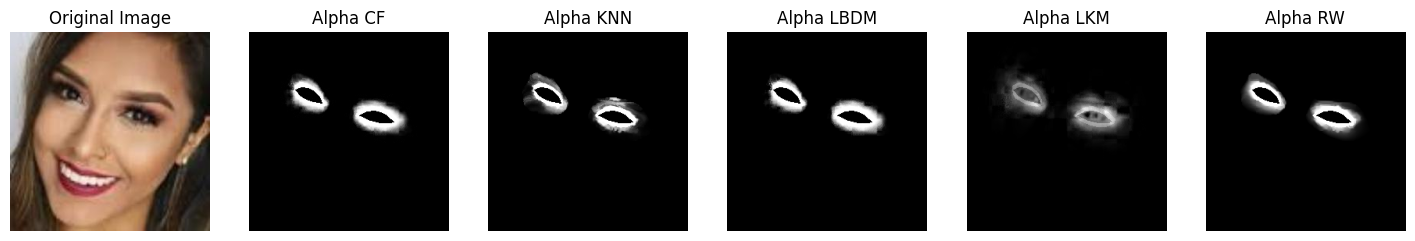

In [51]:
import matplotlib.pyplot as plt

# 加載圖像和 trimap
image = load_image("./256img_lst/001.jpg", "RGB")
trimap = load_image("./trimap/001.jpg", "GRAY")

# 計算 alpha matte，使用相同的 dummy 函數模擬各種方法
alpha_methods = {
    "Alpha CF": estimate_alpha_cf(
    image,
    trimap,
    laplacian_kwargs={"epsilon": 1e-6},
    cg_kwargs={"maxiter":2000}),
    
    "Alpha KNN": estimate_alpha_knn(
    image,
    trimap,
    laplacian_kwargs={"n_neighbors": [15, 10]},
    cg_kwargs={"maxiter":2000}),
    
    "Alpha LBDM": estimate_alpha_lbdm(image, trimap),
    "Alpha LKM": estimate_alpha_lkm(image, trimap),
    "Alpha RW": estimate_alpha_rw(image, trimap)
}

# 創建 subplot
fig, axs = plt.subplots(1, len(alpha_methods) + 1, figsize=(18, 6))

# 顯示原始圖像
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis('off')

# 顯示不同方法估計的 alpha matte
for ax, (title, alpha) in zip(axs[1:], alpha_methods.items()):
    ax.imshow(alpha, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# 顯示圖像
plt.show()


c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)
(1, 128, 128, 1)


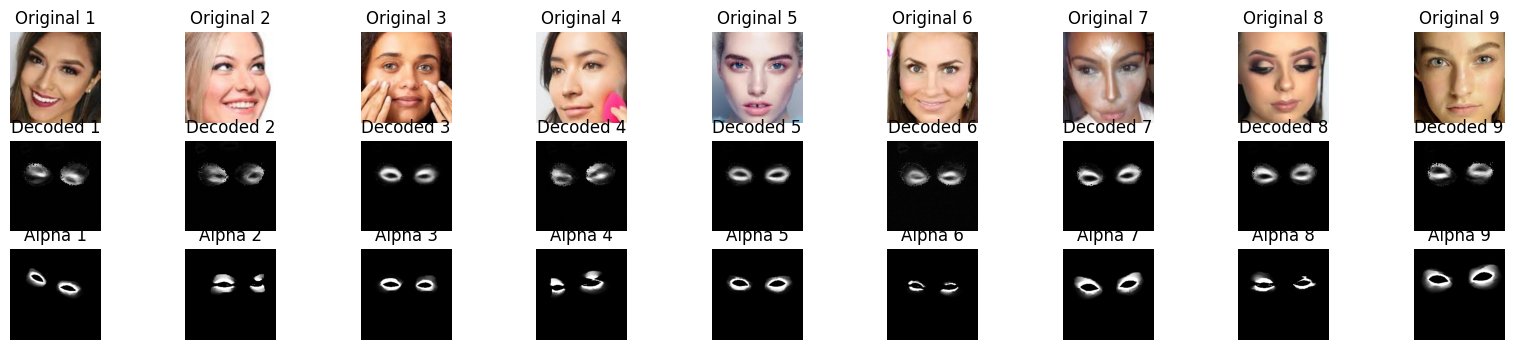

In [3]:
#測試版1
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from pymatting import *

#=============================================================
rightEyeUpper0 =  [246, 161, 160, 159, 158, 157, 173]
rightEyeUpper1 = [247, 30, 29, 27, 28, 56, 190]
rightEyeLower0 = [33, 7, 163, 144, 145, 153, 154, 155, 133]
rightEyeLower1 = [130, 25, 110, 24, 23, 22, 26, 112, 243]
rightEyeLower3 = [143, 111, 117, 118, 119, 120, 121, 128, 245]
rightEyebrowLower = [ 124, 46, 53, 52, 65, 193]
leftEyeUpper0 = [466, 388, 387, 386, 385, 384, 398]
leftEyeUpper1 = [467, 260, 259, 257, 258, 286, 414]
leftEyeLower0 = [263, 249, 390, 373, 374, 380, 381, 382, 362]
leftEyeLower1 = [359, 255, 339, 254, 253, 252, 256, 341, 463]
leftEyeLower3 = [372, 340, 346, 347, 348, 349, 350, 357, 465]
leftEyebrowLower = [276, 283, 282, 295, 285]
#=============================================================

save_dir = 'C:/DL_model/eyemask_model'
# save_dir = 'C:\DL_model\saved_model'
# save_dir = 'C:\\DL_model\\densenet_model'

# 加载模型
loaded_model = keras.models.load_model(save_dir)

# 读取图像并进行预测
fig, axs = plt.subplots(3, 9, figsize=(20, 4))
image_paths = [f"./256img_lst/00{i}.jpg" for i in range(1, 10)]

for n, image_path in enumerate(image_paths):
    # image = load_image(image_path, "RGB")
    image=cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    origin_img=rgb_image.copy()
    # re_img = load_image(image_path, "GRAY")
    #=======================================================================================================
    
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    
    rightEyeLower0.reverse()
    rightEyeLower1.reverse()
    rightEyeLower3.reverse()
    leftEyeLower0.reverse()
    leftEyeLower1.reverse()
    leftEyeLower3.reverse()
    
    # image=frame
    righteyeout_position = []
    righteyein_position = []
    lefteyeout_position = []
    lefteyein_position = []
    righteyemargin_position = []
    lefteyemargin_position = []
# Convert the BGR image to RGB
    height, width, _ = image.shape
    
    results = face_mesh.process(rgb_image)
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            
            # Right Eye out region
            for i in rightEyebrowLower+rightEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyeout_position.append([x,y])
            righteyeout_position = np.array(righteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            # Right Eye margin region        
            for i in rightEyeUpper1+rightEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyemargin_position.append([x,y])
            righteyemargin_position = np.array(righteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyemargin_position],(255,255,255))  
            # Right Eye in region
            for i in rightEyeLower0+rightEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyein_position.append([x,y])
            righteyein_position = np.array(righteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [righteyein_position],(0, 0, 0))      
            # Left Eye out region
            for i in leftEyebrowLower+leftEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyeout_position.append([x,y])
            lefteyeout_position = np.array(lefteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            # Left Eye margin region        
            for i in leftEyeUpper1+leftEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyemargin_position.append([x,y])
            lefteyemargin_position = np.array(lefteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyemargin_position],(255,255,255))        
            for i in leftEyeLower0+leftEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyein_position.append([x,y])
            lefteyein_position = np.array(lefteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [lefteyein_position],(0, 0, 0)) 
            
            mask = np.zeros_like(image)
            cv2.fillPoly(mask, [righteyeout_position], (255, 255, 255))
            cv2.fillPoly(mask, [lefteyeout_position], (255, 255, 255))
            image = cv2.bitwise_and(image, mask)        
            mask2 = np.zeros_like(image)
            condition = (image != [0, 0, 0])
            condition2 = (image == [255, 255, 255])
            condition = condition.all(axis=-1)
            condition2 = condition2.all(axis=-1)
            mask2[condition] = [128,128,128]
            # mask2[condition] = [255,255,255]
            mask2[condition2] = [255,255,255]
            

    #=======================================================================================================
    
    re_img = cv2.resize(mask2,(128,128))
    re_img = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    # re_img = cv2.resize(re_img,(128,128))
    # 调整图像大小并添加维度
    re_img = np.expand_dims(re_img, axis=-1)
    re_img = np.expand_dims(re_img, axis=0)  # 添加批次维度
    print(re_img.shape)
    re_img = re_img.astype('float32') / 255.0  # 确保数据类型为float32

    # 使用加载的模型进行预测
    encoded_imgs = loaded_model.encoder(re_img).numpy()
    decoded_imgs = loaded_model.decoder(encoded_imgs).numpy()
    decoded_imgs = decoded_imgs.reshape(128, 128)

    # 显示原始图像
    axs[0, n].imshow(origin_img)
    axs[0, n].axis('off')
    axs[0, n].set_title(f'Original {n+1}')

    # 显示解码后的图像
    axs[1, n].imshow(decoded_imgs, cmap='gray')
    axs[1, n].axis('off')
    axs[1, n].set_title(f'Decoded {n+1}')
        # 使用 estimate_alpha_rw 函數計算 alpha 混合
    mask2_gray = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
    alpha = estimate_alpha_rw(origin_img/ 255.0, mask2_gray)
    
    axs[2, n].imshow(alpha, cmap='gray')
    axs[2, n].axis('off')
    axs[2, n].set_title(f'Alpha {n+1}')

plt.show()


c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


AttributeError: 'Functional' object has no attribute 'encoder'

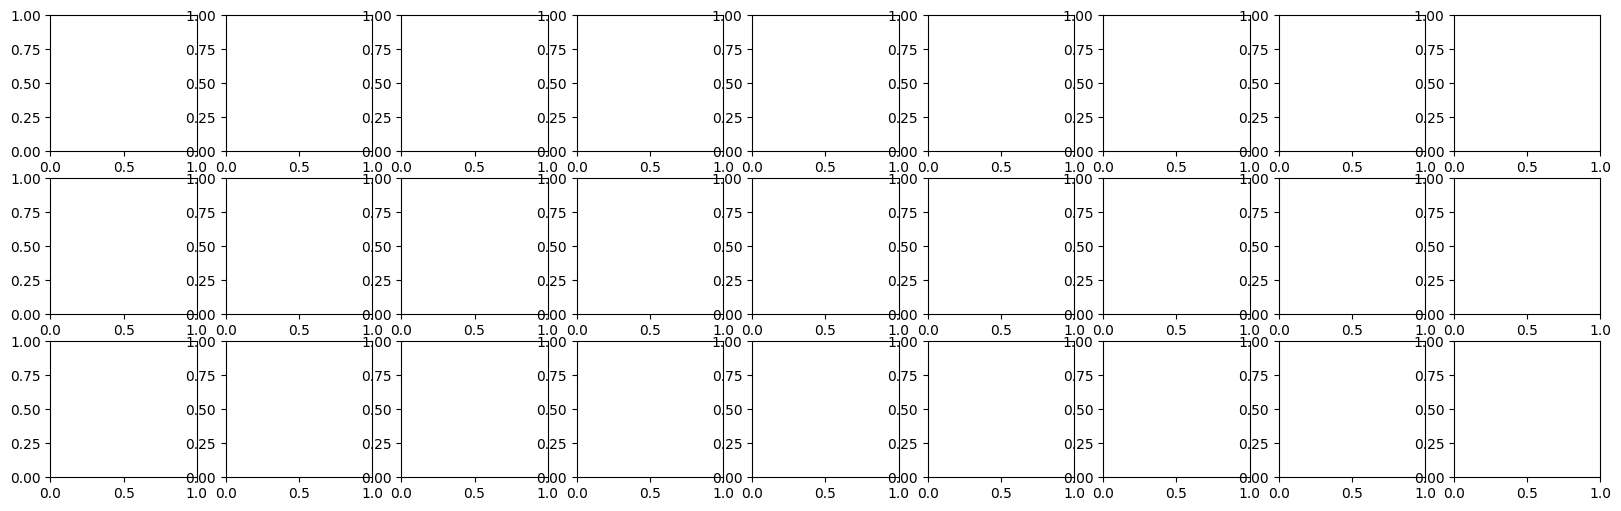

In [2]:
#簡化版，母湯
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from pymatting import estimate_alpha_rw

#=============================================================
rightEyeUpper0 =  [246, 161, 160, 159, 158, 157, 173]
rightEyeUpper1 = [247, 30, 29, 27, 28, 56, 190]
rightEyeLower0 = [33, 7, 163, 144, 145, 153, 154, 155, 133]
rightEyeLower1 = [130, 25, 110, 24, 23, 22, 26, 112, 243]
rightEyeLower3 = [143, 111, 117, 118, 119, 120, 121, 128, 245]
rightEyebrowLower = [124, 46, 53, 52, 65, 193]
leftEyeUpper0 = [466, 388, 387, 386, 385, 384, 398]
leftEyeUpper1 = [467, 260, 259, 257, 258, 286, 414]
leftEyeLower0 = [263, 249, 390, 373, 374, 380, 381, 382, 362]
leftEyeLower1 = [359, 255, 339, 254, 253, 252, 256, 341, 463]
leftEyeLower3 = [372, 340, 346, 347, 348, 349, 350, 357, 465]
leftEyebrowLower = [276, 283, 282, 295, 285]
#=============================================================

save_dir = 'C:\DL_model\densenet_model'

# 加载模型
loaded_model = tf.keras.models.load_model(save_dir)

def get_eye_region(face_landmarks, eye_landmarks, width, height):
    positions = []
    for i in eye_landmarks:
        lm = face_landmarks.landmark[i]
        x, y = int(lm.x * width), int(lm.y * height)
        positions.append([x, y])
    return np.array(positions, dtype=np.int32).reshape((-1, 1, 2))

def fill_eye_regions(image, face_landmarks, width, height):
    regions = [
        (rightEyebrowLower + rightEyeLower3, (255, 255, 255)),  # Right eye out
        (rightEyeUpper1 + rightEyeLower1, (255, 255, 255)),     # Right eye margin
        (rightEyeLower0 + rightEyeUpper0, (0, 0, 0)),           # Right eye in
        (leftEyebrowLower + leftEyeLower3, (255, 255, 255)),    # Left eye out
        (leftEyeUpper1 + leftEyeLower1, (255, 255, 255)),       # Left eye margin
        (leftEyeLower0 + leftEyeUpper0, (0, 0, 0))              # Left eye in
    ]
    mask = np.zeros_like(image)
    for eye_landmarks, color in regions:
        positions = get_eye_region(face_landmarks, eye_landmarks, width, height)
        cv2.fillPoly(image, [positions], color)
        cv2.fillPoly(mask, [positions], color)
    return mask

# 读取图像并进行预测
fig, axs = plt.subplots(3, 9, figsize=(20, 6))
image_paths = [f"./256img_lst/00{i}.jpg" for i in range(1, 10)]

for n, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    origin_img = rgb_image.copy()
    
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
    
    height, width, _ = image.shape
    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style())
            mask = fill_eye_regions(image, face_landmarks, width, height)
            image = cv2.bitwise_and(image, mask)
            mask2 = np.zeros_like(image)
            condition = (image != [0, 0, 0])
            condition2 = (image == [255, 255, 255])
            condition = condition.all(axis=-1)
            condition2 = condition2.all(axis=-1)
            mask2[condition] = [255, 255, 255]
            mask2[condition2] = [255, 255, 255]
    
    re_img = cv2.resize(mask2, (128, 128))
    re_img = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    re_img = np.expand_dims(re_img, axis=-1)
    re_img = np.expand_dims(re_img, axis=0)
    re_img = re_img.astype(np.float64)
    encoded_imgs = loaded_model.encoder(re_img).numpy()
    decoded_imgs = loaded_model.decoder(encoded_imgs).numpy()
    decoded_imgs = decoded_imgs.reshape(128, 128)
    
    axs[0, n].imshow(origin_img)
    axs[0, n].axis('off')
    axs[0, n].set_title(f'Original {n+1}')
    
    axs[1, n].imshow(decoded_imgs, cmap='gray')
    axs[1, n].axis('off')
    axs[1, n].set_title(f'Decoded {n+1}')
    
    mask2_gray = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
    alpha = estimate_alpha_rw(origin_img/ 255.0, mask2_gray)
    
    axs[2, n].imshow(alpha, cmap='gray')
    axs[2, n].axis('off')
    axs[2, n].set_title(f'Alpha {n+1}')

plt.show()


In [5]:
#跑得動版
import cv2
import mediapipe as mp
import numpy as np
import os


save_dir = 'C:/DL_model/eyemask_model'
loaded_model = tf.keras.models.load_model(save_dir)
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Initialize drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


rightEyeUpper0 =  [246, 161, 160, 159, 158, 157, 173]
rightEyeUpper1 = [247, 30, 29, 27, 28, 56, 190]
rightEyeLower0 = [33, 7, 163, 144, 145, 153, 154, 155, 133]
rightEyeLower1 = [130, 25, 110, 24, 23, 22, 26, 112, 243]
rightEyeLower3 = [143, 111, 117, 118, 119, 120, 121, 128, 245]
rightEyebrowLower = [ 124, 46, 53, 52, 65, 193]

leftEyeUpper0 = [466, 388, 387, 386, 385, 384, 398]
leftEyeUpper1 = [467, 260, 259, 257, 258, 286, 414]
leftEyeLower0 = [263, 249, 390, 373, 374, 380, 381, 382, 362]
leftEyeLower1 = [359, 255, 339, 254, 253, 252, 256, 341, 463]
leftEyeLower3 = [372, 340, 346, 347, 348, 349, 350, 357, 465]
leftEyebrowLower = [276, 283, 282, 295, 285]

rightEyeLower0.reverse()
rightEyeLower1.reverse()
rightEyeLower3.reverse()
leftEyeLower0.reverse()
leftEyeLower1.reverse()
leftEyeLower3.reverse()


cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    image=frame
    
    righteyeout_position = []
    righteyein_position = []
    lefteyeout_position = []
    lefteyein_position = []
    righteyemargin_position = []
    lefteyemargin_position = []
# Convert the BGR image to RGB
    height, width, _ = image.shape
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            
            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            
            # Right Eye out region
            for i in rightEyebrowLower+rightEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyeout_position.append([x,y])
            righteyeout_position = np.array(righteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            
            # Right Eye margin region        
            for i in rightEyeUpper1+rightEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyemargin_position.append([x,y])
            righteyemargin_position = np.array(righteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyemargin_position],(255,255,255))  
            
            # Right Eye in region
            for i in rightEyeLower0+rightEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyein_position.append([x,y])
            righteyein_position = np.array(righteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [righteyein_position],(0, 0, 0))      
                    
            # Left Eye out region
            for i in leftEyebrowLower+leftEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyeout_position.append([x,y])
            lefteyeout_position = np.array(lefteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            
            # Left Eye margin region        
            for i in leftEyeUpper1+leftEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyemargin_position.append([x,y])
            lefteyemargin_position = np.array(lefteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyemargin_position],(255,255,255))        
            
            for i in leftEyeLower0+leftEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyein_position.append([x,y])
            lefteyein_position = np.array(lefteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [lefteyein_position],(0, 0, 0))
            
            mask = np.zeros_like(image)
            
            cv2.fillPoly(mask, [righteyeout_position], (255, 255, 255))
            cv2.fillPoly(mask, [lefteyeout_position], (255, 255, 255))
            image = cv2.bitwise_and(image, mask)        
            mask2 = np.zeros_like(image)
            condition = (image != [0, 0, 0])
            condition2 = (image == [255, 255, 255])
            condition = condition.all(axis=-1)
            condition2 = condition2.all(axis=-1)
            # mask2[condition] = [128,128,128]#0,128,255版
            mask2[condition] = [255,255,255]#0,255版
            mask2[condition2] = [255,255,255]
            
            inverted_mask2 = cv2.bitwise_not(mask2)      
            image = cv2.bitwise_and(image, inverted_mask2)        
#======================================================================
#0,128,255版
    # mask2_gray = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
    # alpha = estimate_alpha_rw(frame/ 255.0, mask2_gray)
#======================================================================
    cv2.imshow('Pose Estimation', mask2)
    # cv2.imshow('Pose Estimation', alpha)
    
    if cv2.waitKey(10) & 0xFF == 27:
        print("Detected 'esc' key press. Exiting loop.")
        break

# 釋放資源
cap.release() 
cv2.destroyAllWindows()

In [2]:
#即時model版
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf

save_dir = 'C:/DL_model/eyemask_model'
# save_dir = 'C:/DL_model/eyemask_model'

loaded_model = tf.keras.models.load_model(save_dir)
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Initialize drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def apply_eyeshade(image, mask, color,region_rate ,const = 0.9 ):
    
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask1 = np.all(mask >255-region_rate*255/100, axis=-1)

    mask2 = image.copy()
    mask2[mask1] = gray_mask[mask1][:, np.newaxis] *color/255

# Parameters for the GuidedFilter
    radius = 10         # Radius of the guided filter
    eps = 0.1         # Regularization parameter (epsilon)

    guided_filter = cv2.ximgproc.createGuidedFilter(guide=gray_mask, radius=radius, eps=eps)
    filtered_mask = guided_filter.filter(mask2)
    result = cv2.addWeighted(image, const, filtered_mask, 1-const, 0)

    return result

# Load image using OpenCV
silhouette =  [
    10,  338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
    397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
    172, 58,  132, 93,  234, 127, 162, 21,  54,  103, 67,  109
  ]


rightEyeUpper0 =  [246, 161, 160, 159, 158, 157, 173]
rightEyeUpper1 = [247, 30, 29, 27, 28, 56, 190]
rightEyeLower0 = [33, 7, 163, 144, 145, 153, 154, 155, 133]
rightEyeLower1 = [130, 25, 110, 24, 23, 22, 26, 112, 243]
rightEyeLower3 = [143, 111, 117, 118, 119, 120, 121, 128, 245]
rightEyebrowLower = [ 124, 46, 53, 52, 65, 193]

leftEyeUpper0 = [466, 388, 387, 386, 385, 384, 398]
leftEyeUpper1 = [467, 260, 259, 257, 258, 286, 414]
leftEyeLower0 = [263, 249, 390, 373, 374, 380, 381, 382, 362]
leftEyeLower1 = [359, 255, 339, 254, 253, 252, 256, 341, 463]
leftEyeLower3 = [372, 340, 346, 347, 348, 349, 350, 357, 465]

rightEyeLower0.reverse()
rightEyeLower1.reverse()
rightEyeLower3.reverse()
leftEyeLower0.reverse()
leftEyeLower1.reverse()
leftEyeLower3.reverse()

leftEyebrowLower = [276, 283, 282, 295, 285]

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    image=frame
    
    righteyeout_position = []
    righteyein_position = []
    lefteyeout_position = []
    lefteyein_position = []
    righteyemargin_position = []
    lefteyemargin_position = []
# Convert the BGR image to RGB
    height, width, _ = image.shape
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process the image to find facial landmarks
    results = face_mesh.process(rgb_image)
    # Check if landmarks were detected
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
    #====================================================================
            x_min = width
            y_min = height
            x_max = y_max = 0

            for lm in face_landmarks.landmark:
                x, y = int(lm.x * width), int(lm.y * height)
                if x < x_min: x_min = x
                if y < y_min: y_min = y
                if x > x_max: x_max = x
                if y > y_max: y_max = y

            # 计算正方形区域
            face_width = x_max - x_min
            face_height = y_max - y_min
            face_size = max(face_width, face_height)
            center_x, center_y = (x_min + x_max) // 2, (y_min + y_max) // 2

            # 确保正方形区域不超出边界
            left = max(center_x - face_size // 2, 0)
            right = min(center_x + face_size // 2, width)
            top = max(center_y - face_size // 2, 0)
            bottom = min(center_y + face_size // 2, height)

            # 裁剪人脸区域并调整大小
            face_crop = frame[top:bottom, left:right]
            face_crop_resized = cv2.resize(face_crop, (256, 256))
            origin_256=cv2.resize(frame[top:bottom, left:right], (256, 256))
    #====================================================================
            # Draw facial landmarks on the image
            mp_drawing.draw_landmarks(
                image=face_crop_resized,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            
            # Right Eye out region
            for i in rightEyebrowLower+rightEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyeout_position.append([x,y])
            righteyeout_position = np.array(righteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            
            # Right Eye margin region        
            for i in rightEyeUpper1+rightEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyemargin_position.append([x,y])
            righteyemargin_position = np.array(righteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyemargin_position],(255,255,255))  
            
            # Right Eye in region
            for i in rightEyeLower0+rightEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyein_position.append([x,y])
            righteyein_position = np.array(righteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [righteyein_position],(0, 0, 0))      
                    
            # Left Eye out region
            for i in leftEyebrowLower+leftEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyeout_position.append([x,y])
            lefteyeout_position = np.array(lefteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            
            # Left Eye margin region        
            for i in leftEyeUpper1+leftEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyemargin_position.append([x,y])
            lefteyemargin_position = np.array(lefteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyemargin_position],(255,255,255))        
            
            for i in leftEyeLower0+leftEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyein_position.append([x,y])
            lefteyein_position = np.array(lefteyein_position, dtype=np.int32).reshape((-1, 1, 2))        
            cv2.fillPoly(image, [lefteyein_position],(0, 0, 0))
        
            mask = np.zeros_like(image)
            cv2.fillPoly(mask, [righteyeout_position], (255, 255, 255))
            cv2.fillPoly(mask, [lefteyeout_position], (255, 255, 255))
            image = cv2.bitwise_and(image, mask)        
            mask2 = np.zeros_like(image)
            condition = (image != [0, 0, 0])
            condition2 = (image == [255, 255, 255])
            condition = condition.all(axis=-1)
            condition2 = condition2.all(axis=-1)
            mask2[condition] = [128,128,128]
            mask2[condition2] = [255,255,255]
            
#======================================================================
            re_img = cv2.resize(mask2,(128,128))
            re_img = cv2.cvtColor(re_img,cv2.COLOR_BGR2GRAY)
            # 调整图像大小并添加维度
            re_img = np.expand_dims(re_img, axis=0)
            re_img = np.expand_dims(re_img, axis=-1)  # 添加批次维度
            re_img = re_img.astype(np.float32)  # 确保数据类型为float32

            # 使用加载的模型进行预测
            encoded_imgs = loaded_model.encoder(re_img).numpy()
            decoded_imgs = loaded_model.decoder(encoded_imgs).numpy()
            decoded_imgs = (decoded_imgs * 255).astype(np.uint8)
            decoded_imgs = decoded_imgs.reshape(128,128)
#======================================================================
            # face_crop_inverted = cv2.resize(decoded_imgs, (right-left,bottom-top ))
            decoded_imgs=cv2.cvtColor(decoded_imgs, cv2.COLOR_GRAY2BGR)
            bgr=(0,255,255)
            region_rate=150
            const=1.1
            
            origin_256=cv2.resize(origin_256,(128,128))
            output_image = apply_eyeshade(origin_256,decoded_imgs, bgr,region_rate,const)
            
            face_crop_inverted = cv2.resize(output_image, (right-left,bottom-top ))
            # face_crop_inverted = cv2.cvtColor(face_crop_inverted, cv2.COLOR_GRAY2BGR)
            frame[top:bottom, left:right] = face_crop_inverted
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
    # cv2.imshow('Pose Estimation', mask2)
    cv2.imshow('mask2', mask2)
    cv2.imshow('decoded_imgs', decoded_imgs)
    cv2.imshow('Pose Estimation', frame)
    
    if cv2.waitKey(10) & 0xFF == 27:
        print("Detected 'esc' key press. Exiting loop.")
        break

# 釋放資源
cap.release() 
cv2.destroyAllWindows()

c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Detected 'esc' key press. Exiting loop.


In [2]:
#將臉部方形反轉顏色
import cv2
import numpy as np
import mediapipe as mp

# 初始化MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# 初始化OpenCV窗口
cv2.namedWindow('MediaPipe Face Mesh', cv2.WINDOW_NORMAL)

cap = cv2.VideoCapture(0)  # 使用默认摄像头

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # 提取所有关键点的坐标
            x_min = w
            y_min = h
            x_max = y_max = 0

            for lm in face_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x < x_min: x_min = x
                if y < y_min: y_min = y
                if x > x_max: x_max = x
                if y > y_max: y_max = y

            # 计算正方形区域
            face_width = x_max - x_min
            face_height = y_max - y_min
            face_size = max(face_width, face_height)
            center_x, center_y = (x_min + x_max) // 2, (y_min + y_max) // 2

            # 确保正方形区域不超出边界
            left = max(center_x - face_size // 2, 0)
            right = min(center_x + face_size // 2, w)
            top = max(center_y - face_size // 2, 0)
            bottom = min(center_y + face_size // 2, h)

            # 裁剪人脸区域并调整大小
            face_crop = frame[top:bottom, left:right]
            face_crop_resized = cv2.resize(face_crop, (256, 256))

            # 对256x256的图像进行RGB颜色反转
            face_crop_resized_inverted = cv2.bitwise_not(face_crop_resized)

            # 将反转后的图像调整回原始大小
            face_crop_inverted = cv2.resize(face_crop_resized_inverted, (right-left, bottom-top))

            # 将反转后的图像粘贴回原始图像中
            frame[top:bottom, left:right] = face_crop_inverted

            # 绘制边界框
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

    cv2.imshow('MediaPipe Face Mesh', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [46]:
#測試臉部方形抓取
import cv2
import numpy as np
import mediapipe as mp

# 初始化MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# 初始化OpenCV窗口
cv2.namedWindow('MediaPipe Face Mesh', cv2.WINDOW_NORMAL)

cap = cv2.VideoCapture(0)  # 使用默认摄像头

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # 提取所有关键点的坐标
            x_min = w
            y_min = h
            x_max = y_max = 0

            for lm in face_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x < x_min: x_min = x
                if y < y_min: y_min = y
                if x > x_max: x_max = x
                if y > y_max: y_max = y

            # 计算正方形区域
            face_width = x_max - x_min
            face_height = y_max - y_min
            face_size = max(face_width, face_height)
            center_x, center_y = (x_min + x_max) // 2, (y_min + y_max) // 2

            # 确保正方形区域不超出边界
            left = max(center_x - face_size // 2, 0)
            right = min(center_x + face_size // 2, w)
            top = max(center_y - face_size // 2, 0)
            bottom = min(center_y + face_size // 2, h)

            # 裁剪人脸区域并调整大小
            face_crop = frame[top:bottom, left:right]
            face_crop_resized = cv2.resize(face_crop, (256, 256))

            # 将裁剪调整大小的图像粘贴到右上角
            frame[0:256, -256:] = face_crop_resized

            # 绘制边界框
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

    cv2.imshow('MediaPipe Face Mesh', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [39]:
#成功切出方塊+眼罩
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf

# 加载模型
# save_dir = 'C:/DL_model/eyemask_model'
save_dir = 'densenet_model/saved_model'
loaded_model = tf.keras.models.load_model(save_dir)

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Initialize drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Define the landmark indices
rightEyeUpper0 = [246, 161, 160, 159, 158, 157, 173]
rightEyeUpper1 = [247, 30, 29, 27, 28, 56, 190]
rightEyeLower0 = [33, 7, 163, 144, 145, 153, 154, 155, 133]
rightEyeLower1 = [130, 25, 110, 24, 23, 22, 26, 112, 243]
rightEyeLower3 = [143, 111, 117, 118, 119, 120, 121, 128, 245]
rightEyebrowLower = [124, 46, 53, 52, 65, 193]

leftEyeUpper0 = [466, 388, 387, 386, 385, 384, 398]
leftEyeUpper1 = [467, 260, 259, 257, 258, 286, 414]
leftEyeLower0 = [263, 249, 390, 373, 374, 380, 381, 382, 362]
leftEyeLower1 = [359, 255, 339, 254, 253, 252, 256, 341, 463]
leftEyeLower3 = [372, 340, 346, 347, 348, 349, 350, 357, 465]
leftEyebrowLower = [276, 283, 282, 295, 285]

# Reverse the order of some lists
rightEyeLower0.reverse()
rightEyeLower1.reverse()
rightEyeLower3.reverse()
leftEyeLower0.reverse()
leftEyeLower1.reverse()
leftEyeLower3.reverse()

def apply_mask_to_face(frame):
    height, width, _ = frame.shape
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    image=frame
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            
            # 获取脸部区域
            x_min = width
            y_min = height
            x_max = y_max = 0

            for lm in face_landmarks.landmark:
                x, y = int(lm.x * width), int(lm.y * height)
                if x < x_min: x_min = x
                if y < y_min: y_min = y
                if x > x_max: x_max = x
                if y > y_max: y_max = y

            # 计算正方形区域
            face_width = x_max - x_min
            face_height = y_max - y_min
            face_size = max(face_width, face_height)
            center_x, center_y = (x_min + x_max) // 2, (y_min + y_max) // 2

            # 确保正方形区域不超出边界
            left = max(center_x - face_size // 2, 0)
            right = min(center_x + face_size // 2, width)
            top = max(center_y - face_size // 2, 0)
            bottom = min(center_y + face_size // 2, height)

            # 生成遮罩 mask2
            
            
            # 右眼上方和下方的区域
            righteyeout_position = []
            for i in rightEyebrowLower + rightEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyeout_position.append([x,y])
            righteyeout_position = np.array(righteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyeout_position], (255, 255, 255))
            
            righteyemargin_position = []
            for i in rightEyeUpper1 + rightEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyemargin_position.append([x,y])
            righteyemargin_position = np.array(righteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyemargin_position], (255, 255, 255))
            
            righteyein_position = []
            for i in rightEyeLower0 + rightEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                righteyein_position.append([x,y])
            righteyein_position = np.array(righteyein_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [righteyein_position], (0, 0, 0))
            
            # 左眼上方和下方的区域
            lefteyeout_position = []
            for i in leftEyebrowLower + leftEyeLower3:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyeout_position.append([x,y])
            lefteyeout_position = np.array(lefteyeout_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyeout_position], (255, 255, 255))
            
            lefteyemargin_position = []
            for i in leftEyeUpper1 + leftEyeLower1:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyemargin_position.append([x,y])
            lefteyemargin_position = np.array(lefteyemargin_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyemargin_position], (255, 255, 255))
            
            lefteyein_position = []
            for i in leftEyeLower0 + leftEyeUpper0:
                lm = face_landmarks.landmark[i]
                x, y = int(lm.x * width), int(lm.y * height)
                lefteyein_position.append([x,y])
            lefteyein_position = np.array(lefteyein_position, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(image, [lefteyein_position], (0, 0, 0))
            
            #===============================================================
            mask = np.zeros_like(image)
        
            cv2.fillPoly(mask, [righteyeout_position], (255, 255, 255))
            cv2.fillPoly(mask, [lefteyeout_position], (255, 255, 255))
            image = cv2.bitwise_and(image, mask)        
            mask2 = np.zeros_like(image)
            condition = (image != [0, 0, 0])
            condition2 = (image == [255, 255, 255])
            condition = condition.all(axis=-1)
            condition2 = condition2.all(axis=-1)
            mask2[condition] = [255,255,255]
            mask2[condition2] = [255,255,255]
            
            #===============================================================
            # 在整个帧上显示 mask2 的效果，框外保持原始图像
            masked_frame = cv2.bitwise_and(frame, mask2)
            mask_pic=masked_frame[top:bottom, left:right] #製作不確定邊長的方形mask_pic
            mask_pic=cv2.resize(mask_pic,(128,128))
            #========================================================模型預測
            re_img=cv2.cvtColor(mask_pic, cv2.COLOR_BGR2GRAY)
            re_img = np.array(mask_pic)
            re_img = re_img.astype('float32') /255
            # re_img = np.expand_dims(re_img, axis=0)
            # re_img = np.expand_dims(re_img, axis=-1)  # 添加批次
            re_img = re_img.reshape((1, 128, 128))
            
            decoded_imgs = loaded_model.predict(re_img)
            # decoded_imgs = (decoded_imgs).astype(np.uint8)
            decoded_imgs = (decoded_imgs*255).reshape(128, 128)
            decoded_imgs = cv2.cvtColor(decoded_imgs, cv2.COLOR_GRAY2RGB)
            #========================================================
            # 在人脸框内显示 mask2 的效果，框外保持原始图像
            frame[top:bottom, left:right] = cv2.resize(decoded_imgs,(right-left,bottom-top))
            # frame[top:bottom, left:right] = cv2.resize(mask_pic,(right-left,bottom-top))

            # 绘制边界框
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

    return frame

# Capture video from webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    result_frame = apply_mask_to_face(frame)
    
    cv2.imshow('Pose Estimation', result_frame)
    
    if cv2.waitKey(10) & 0xFF == 27:
        print("Detected 'esc' key press. Exiting loop.")
        break

# 释放资源
cap.release()
cv2.destroyAllWindows()


c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


ValueError: cannot reshape array of size 49152 into shape (1,128,128)